# Using Unsupervised and Supervised Machine Learning to Discover Discrepancies Between the Two Counter-Circulating Beams of the Large Hadron Collider

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker # for spacing out Fill number labels on x-axis
import pandas as pd
import math
import statistics
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import svm
from scipy.spatial.distance import cdist # for Euclidean distance
from mpl_toolkits.mplot3d import Axes3D

## Load data


This data must be available before running this notebook.  Run the `Data collection.ipynb` notebook to collect the data if it does not exist.

In [2]:
# Read saved DataFrames (result of Data collection notebook)
lossDfs = {
    'start_ramp': pd.read_pickle("data/pickles/startRampLosses.pkl"),
    'flat_top': pd.read_pickle("data/pickles/flatTopLosses.pkl"),
    'start_squeeze': pd.read_pickle("data/pickles/startSqueezeLosses.pkl"),
    'start_adjust': pd.read_pickle("data/pickles/startAdjustLosses.pkl")
}

# Copy timestamps column from the loss DataFrames
timestamps = {phaseName: lossDf['timestamp'] for phaseName, lossDf in lossDfs.items()}

# Remove timestamps column from the loss DataFrames so that it does not interfere (eg. with standardisation, clustering etc) 
for phaseName, lossDf in lossDfs.items():
    lossDf.drop(columns='timestamp', inplace=True)

## Preprocessing

### Check variances, range

In [3]:
def printMinMaxStdDev(lossDfs):
    """Prints the minimum and maximum feature standard deviation in lossDfs    
    
    Parameters
    ----------
    lossDfs : dict of str to DataFrame
        keys: phase name, values: loss DataFrame, without timestamps column, but otherwise identical in structure to the
        DataFrames saved by the Data Collection notebook.
    """
    for phaseName, lossDf in lossDfs.items():
        stds = lossDf.std().sort_values()
        
        print(phaseName)
        print(f'\t\tMin: {stds.keys()[0]}  {stds.iloc[0]}')
        print(f'\t\tMax: {stds.keys()[-1]}  {stds.iloc[-1]}')

In [4]:
def printMinMaxRange(lossDfs):
    """Prints the minimum and maximum feature range in lossDfs    
    
    Parameters
    ----------
    lossDfs : dict of str to DataFrame
        keys: phase name, values: loss DataFrame, without timestamps column, but otherwise identical in structure to the
        DataFrames saved by the Data Collection notebook.
    """
    for phaseName, lossDf in lossDfs.items():
        ranges = (lossDf.max() - lossDf.min()).sort_values()

        print(phaseName)
        print(f'\t\tMin: {ranges.keys()[0]}  {ranges.iloc[0]}')
        print(f'\t\tMax: {ranges.keys()[-1]}  {ranges.iloc[-1]}')

In [5]:
printMinMaxStdDev(lossDfs)

start_ramp
		Min: TCL.6x1  3.756342035149068e-08
		Max: TCP.6x3  0.037443085673988796
flat_top
		Min: TCL.6x1  1.225111181727108e-07
		Max: TCLA.A6x7  0.15853433213654786
start_squeeze
		Min: TCL.6x1  1.2364519340628526e-07
		Max: TCLA.A6x7  0.16196442637421815
start_adjust
		Min: TCTPV.4x2  1.1267715631305227e-06
		Max: TCLA.A6x7  0.09298262645223557


In [6]:
printMinMaxRange(lossDfs)

start_ramp
		Min: TCL.6x1  2.762e-07
		Max: TCP.6x3  0.2134994476
flat_top
		Min: TCL.6x1  7.043000000000001e-07
		Max: TCLA.A6x7  0.5663990085
start_squeeze
		Min: TCL.6x1  7.043000000000001e-07
		Max: TCLA.A6x7  0.5322993979
start_adjust
		Min: TCL.6x1  5.233999999999999e-06
		Max: TCLA.A6x7  0.48949871899999997


There is a large difference in order of magnitude in variance and range between the BLMs.  We must standardise the features so that BLMs with relatively high variance do not dominate the clustering and PCA calculations.

### Standardise data

In [7]:
scaler = StandardScaler()

for phaseName, lossDf in lossDfs.items():
    lossDf.loc[:] = scaler.fit_transform(lossDf.loc[:])

In [8]:
printMinMaxStdDev(lossDfs)

start_ramp
		Min: TCL.4x1  1.0016597521794572
		Max: TCTPV.4x5  1.0016597521794586
flat_top
		Min: TCDSB.4x6  1.0016597521794568
		Max: TCL.6x5  1.0016597521794586
start_squeeze
		Min: TCSG.E5x7  1.0021810276726821
		Max: TCSG.5x3  1.002181027672683
start_adjust
		Min: TCLA.A6x7  1.0020898664383395
		Max: TCP.B6x7  1.0020898664383406


In [9]:
printMinMaxRange(lossDfs)

start_ramp
		Min: TCL.4x5  3.965838864779768
		Max: TCTPH.4x2  16.874851934056302
flat_top
		Min: TCLA.A5x3  2.5507500758100665
		Max: TCDSB.4x6  16.602470355367135
start_squeeze
		Min: TCSG.4x3  3.0217066644042303
		Max: TCTPV.4x5  12.77146704588559
start_adjust
		Min: TCL.4x1  2.654624658530265
		Max: TCSP.A4x6_2  15.050276781466394


### Dimensionality reduction using PCA

#### Explained variance ratio bar chart

<IPython.core.display.Javascript object>


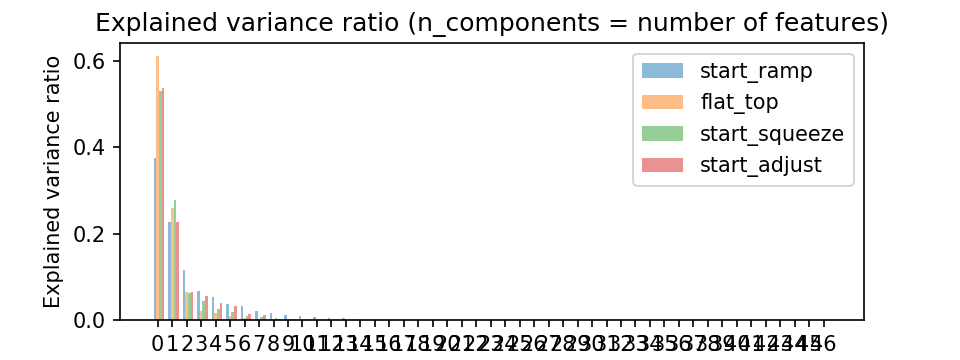

Variance explained by the first 3 principal components:
start_ramp	71.87%
flat_top	93.59%
start_squeeze	87.08%
start_adjust	82.97%


In [10]:
pca = PCA()  # n_components not set => keep all components
fig, ax = plt.subplots(figsize=[6.4, 2.4])

# ensure that each lossDf in lossDfs has the same number of columns
assert len(set(map(lambda lossDf: len(lossDf.columns), lossDfs.values()))) == 1

xs = np.arange(len(lossDfs['start_ramp'].columns))
barWidth = 0.18

print('Variance explained by the first 3 principal components:')
for i, (phaseName, lossDf) in enumerate(lossDfs.items()):
    pca.fit(lossDf)
    assert len(pca.explained_variance_ratio_) == len(lossDf.columns)
    print(f'{phaseName}\t{sum(pca.explained_variance_ratio_[:3]):.2%}')
    
    ax.bar(xs + (i * barWidth), pca.explained_variance_ratio_, barWidth, alpha=0.5, label=phaseName)

ax.set_ylabel('Explained variance ratio')
ax.set_xlabel('Principal components')
ax.set_xticks(xs + barWidth)
ax.set_xticklabels(xs)
ax.set_title('Explained variance ratio (n_components = number of features)')
ax.legend()

####  Reducing to 3 dimensions

In [11]:
pca = PCA(n_components=3, whiten=True)
# From https://scikit-learn.org/stable/modules/decomposition.html#pca
# The optional parameter whiten=True makes it possible to project the data onto the singular space while scaling each 
# component to unit variance. This is often useful if the models down-stream make strong assumptions on the isotropy 
# of the signal: this is for example the case for Support Vector Machines with the RBF kernel and the K-Means clustering 
# algorithm.

lossDfsPCA = {
    phaseName: pd.DataFrame(data=pca.fit_transform(lossDf), index=lossDf.index, columns=['PCA1', 'PCA2', 'PCA3'])
    for phaseName, lossDf in lossDfs.items()
}

Using PCA parameter `whiten=True`, we get unit variance.  This is useful for clustering algorithms (k-means, DBSCAN) that assume the signal is isotropic in all directions.

In [12]:
printMinMaxStdDev(lossDfsPCA)

start_ramp
		Min: PCA1  1.0000000000000002
		Max: PCA2  1.0000000000000004
flat_top
		Min: PCA2  1.0
		Max: PCA1  1.0000000000000007
start_squeeze
		Min: PCA3  1.0
		Max: PCA1  1.0000000000000013
start_adjust
		Min: PCA1  0.9999999999999998
		Max: PCA3  0.9999999999999999


In [13]:
printMinMaxRange(lossDfsPCA)

start_ramp
		Min: PCA1  5.833453829663215
		Max: PCA2  10.28773168376074
flat_top
		Min: PCA1  3.3740316096302987
		Max: PCA3  17.419858042487327
start_squeeze
		Min: PCA1  3.5551775358478928
		Max: PCA3  10.912864727707214
start_adjust
		Min: PCA1  4.045783097451641
		Max: PCA3  10.034931012938461


## Visualising the 3D PCA data

### Helper functions

In [14]:
def is3D(lossDf):
    """ Checks if lossDf has 3 features (3 columns).  Used to check if possible to make a 3D plot.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
        
    Returns
    -------
    bool
    """
    
    return len(lossDf.columns) == 3

In [15]:
def scatterPlotLosses(lossDf, title="", ax=None):
    """ Makes a 3D scatter plot of the provided losses, with a legend denoting B1 and B2 losses.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    title : str, optional
        The title to give the plot.  Defaults to the empty string.
    ax : Axes3D object, optional
        The axes on whih to draw the plot.  Defaults to none, in which case a new figure and Axes3d object will be made.
    """
    noExistingAxes = (ax == None)

    if noExistingAxes:
        fig = plt.figure(figsize=[4, 4])
        ax = fig.add_subplot(111, projection='3d')
    
    xs = lossDf.loc['B1'][lossDf.columns[0]]
    ys = lossDf.loc['B1'][lossDf.columns[1]]
    zs = lossDf.loc['B1'][lossDf.columns[2]]
    ax.scatter(xs, ys, zs, c='red', label='B1')

    xs = lossDf.loc['B2'][lossDf.columns[0]]
    ys = lossDf.loc['B2'][lossDf.columns[1]]
    zs = lossDf.loc['B2'][lossDf.columns[2]]
    ax.scatter(xs, ys, zs, c='black', label='B2')

    ax.set_title(title)
    ax.set_xlabel(lossDf.columns[0])
    ax.set_ylabel(lossDf.columns[1])
    ax.set_zlabel(lossDf.columns[2])
    ax.add_artist(ax.legend(framealpha=0.5, loc="lower left"))
    
    if noExistingAxes:
        plt.show()

### Plotting

<IPython.core.display.Javascript object>


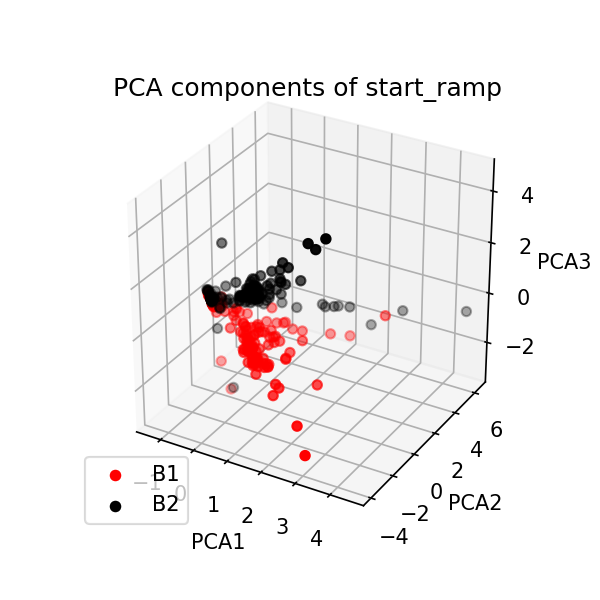

<IPython.core.display.Javascript object>


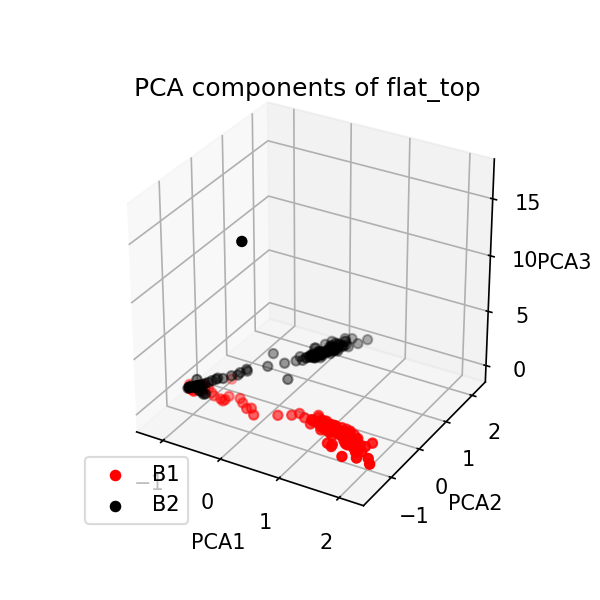

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


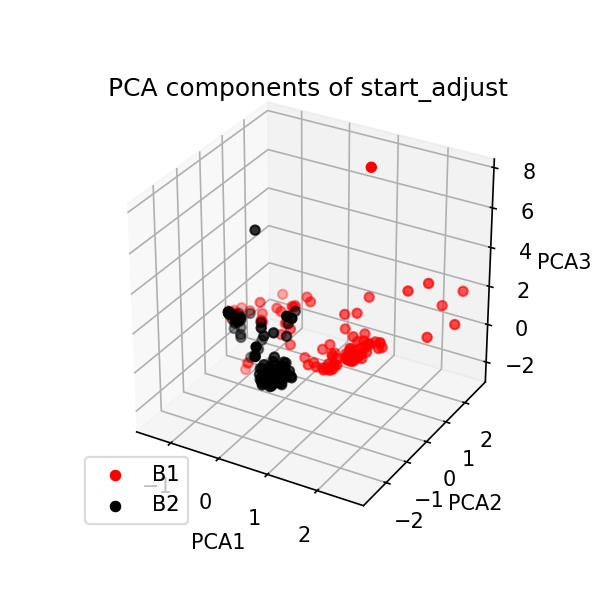

In [16]:
for phaseName, lossDf in lossDfsPCA.items():
    scatterPlotLosses(lossDf, f"PCA components of {phaseName}")

## Euclidean distance

### Helper functions

To get Euclidean distance between the BLM vectors for beam 1 and beam 2

In [17]:
def getEuclideanDistance(lossDf):
    """
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    
    Returns
    -------
    pandas.Series object
        Indexed by fill number, contains the Euclidean distance between each B1, B2 row of `lossDf` corresponding by
        fill number.
    """
    return pd.Series(cdist(lossDf.loc['B1'].values, lossDf.loc['B2'].values, metric='euclidean').diagonal(),
                     index=lossDf.loc['B1'].index) # to preserve the fill numbers for x-axis of the euclidean distance plot

# getting diagonal to get the euclidean distance of pairs of vectors we care about (i.e. corresponding rows)
# ie. euclidean distance between row 0 of B1 values, row 0 of B2 values; euclidean distance between row 1 of B1 values,
# row 1 of B2 values, and so on.

# to confirm values are correct:
# from scipy.spatial.distance import euclidean
# print(distance)
# print(euclidean(mergedPhaselossDf.loc['B1'].iloc[0], mergedPhaselossDf.loc['B2'].iloc[0]))
# print(euclidean(mergedPhaselossDf.loc['B1'].iloc[1], mergedPhaselossDf.loc['B2'].iloc[1]))
# ...

In [18]:
def plotEuclideanDistance(lossDfs, titleStr):
    distances = {phaseName: getEuclideanDistance(lossDf) for phaseName, lossDf in lossDfs.items()}
    
    fig, ax = plt.subplots()
    ax.set_yscale('log')

    for phaseName in distances:
        ax.plot(phaseName, data=distances, marker='x', label=phaseName)

    ax.set(xlabel='Fill',
           ylabel='Euclidean distance',
           title=titleStr)

    ax.legend()
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))  # set freqeuency of x-axis labels (fill numbers)

### Analysis

#### Full feature-space

In [19]:
plotEuclideanDistance(lossDfs, 'Plot of Euclidean distance between B1, B2 BLM vectors')

<IPython.core.display.Javascript object>

#### PCA features

<IPython.core.display.Javascript object>


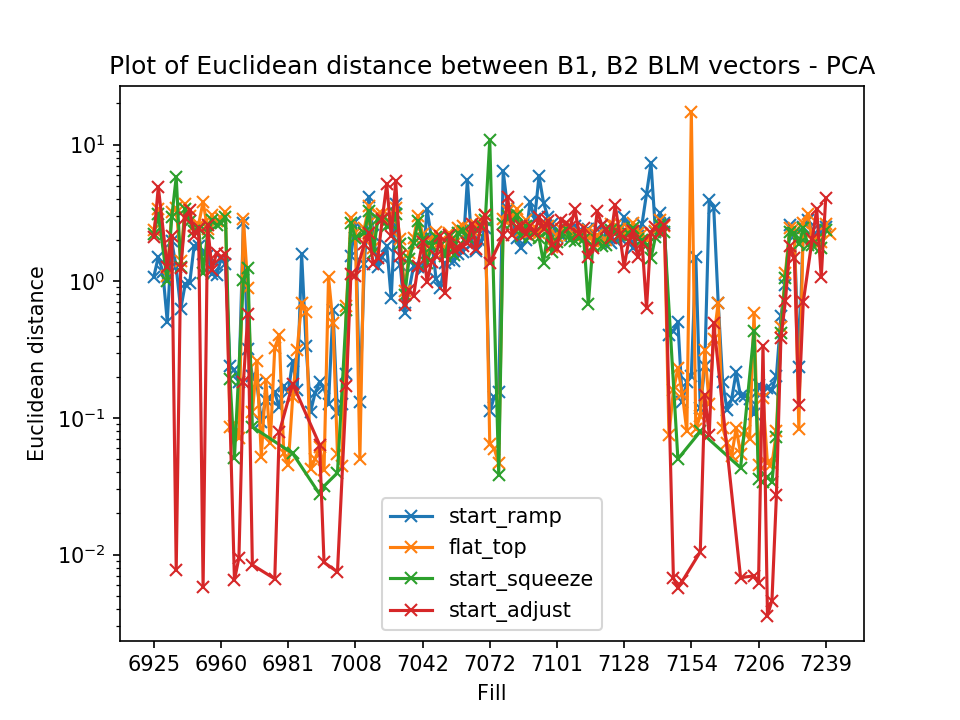

In [20]:
plotEuclideanDistance(lossDfsPCA, 'Plot of Euclidean distance between B1, B2 BLM vectors - PCA')

## Clustering classes and functions

In [21]:
class Cluster:
    """Used to hold information about a cluster.
    
    Attributes
    ----------
    clusterNo : int
        See __init__ parameter
    trainingSamplesCount : int
        number of samples (i.e. losses) used to perform the clustering
    b1Count : int
        number of beam 1 losses in the cluster
    b2Count : int
        number of beam 2 losses in the cluster
    size : int
        size of the cluster, i.e. number of losses in the cluster
    b1Proportion : float
        The proportion of beam 1 losses in the cluster i.e. b1Count / size
    b2Proportion : float
        The proportion of beam 2 losses in the cluster i.e. b2Count / size
    accuracy : float
        The maximum out of b1Proportion and b2Proportion - whichever is highest dictates which class the cluster represents
        (B1 or B2).  eg. if the cluster has b1Proportion > b2Proportion, then beam 2 points in this cluster are errors.
    timestampsStdDev : float
        The standard deviation of the timestamps of the losses in this cluster
    timestampsMean : float
        The mean of the timestamps of the losses in this cluster
    """
    def __init__(self, clusterNo, labels, timestamps):
        """Determines information about a cluster - size, proportion B1 and B2, accuracy, timestamp std dev and mean.
        
        Parameters
        ----------
        clusterNo : int
            Label of this cluster, taken from the labels list returned by the scikit-learn clustering method
        labels : list of int
            Cluster labels returned by the scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample.
        timestamps : Series of float
            Timestamps corresponding to each training sample.
        """
        
        self.clusterNo = clusterNo
        self.trainingSamplesCount = len(labels)
        
        # split labels into two halves - the first half corresponds to B1 losses, the second half to B2 losses
        # (this is how the losses DataFrames are organised)
        assert len(labels) % 2 == 0
        b1Labels = list(labels[: len(labels)//2])
        b2Labels = list(labels[len(labels)//2 :])
        
        # count number of times this clusterNo appears in the B1, B2 part of labels
        self.b1Count = b1Labels.count(clusterNo)
        self.b2Count = b2Labels.count(clusterNo)
        self.size = self.b1Count + self.b2Count
        
        self.b1Proportion = self.b1Count / self.size
        self.b2Proportion = self.b2Count / self.size
        self.accuracy = max(self.b1Proportion, self.b2Proportion)
        
        # calculate standard deviation and mean of timestamps of losses in this cluster
        lossesInClusterIndices = np.where(labels == clusterNo)[0]
        timestamps = timestamps.iloc[lossesInClusterIndices]
        
        self.timestampsStdDev = timestamps.std()
        if math.isnan(self.timestampsStdDev):  # Series.std() return Nan when there is only one value in the cluster
            self.timestampsStdDev = 0
        
        self.timestampsMean = timestamps.mean()
        
    def describe(self):
        """Prints the cluster label, size, B1-B2 proportions, and timestamps std dev and mean."""
        
        print(f'\tCluster {self.clusterNo}\n'
        f'\t\tProportion\t{(self.size / self.trainingSamplesCount):.2%} ({self.size}/{self.trainingSamplesCount})\n'
        f'\t\tof which B1\t{self.b1Proportion:.2%} ({self.b1Count}/{self.size})\n'
        f'\t\tof which B2\t{self.b2Proportion:.2%} ({self.b2Count}/{self.size})\n'
        f"\t\tTime std dev\t{pd.Timedelta(self.timestampsStdDev, unit='s').round('1s')}\n"
        f"\t\tTime mean\t{pd.Timestamp(self.timestampsMean, unit='s').round('1s')}\n")

In [22]:
class ClusteringResult:
    """Used to hold information about a clustering result (i.e. the labels returned by a clustering method eg. KMeans, DBSCAN)
    
    Attributes
    ----------
    labels : list of int
        See __init__ parameter
    clusters : dict of int to Cluster objects
        key is cluster number (taken from labels), value is the corresponding Cluster object
    averageAccuracy : float
        The average of the clusters' accuracies
    """
    def __init__(self, labels, timestamps):
        """Instantiates Cluster objects for each of the clusters in labels.  Calculates the average accuracy.
        
        Note:  Loops from min cluster label to max cluster label in order to instantiate each Cluster.
        
        Parameters
        ----------
        labels : list of int
            Cluster labels returned by a scikit-learn clustering method.  There should be an element (i.e. a label)
            for every training sample (i.e. every row in the losses DataFrame)
        timestamps : Series of float
            Timestamps corresponding to each training sample.
        """
        self.labels = labels
        self.clusters = {}
        
        # instantiate a Cluster object for each unique cluster label in labels
        for clusterNo in range(min(labels), max(labels) + 1):
            self.clusters[clusterNo] = Cluster(clusterNo, labels, timestamps)
        
        # assert that the sum of the sizes of each cluster adds up to the number of training samples, to ensure that
        # every training sample was assigned a cluster
        sizes = list(map(lambda cluster: cluster.size, self.clusters.values()))
        assert sum(sizes) == len(labels) 
        
        accuracies = list(map(lambda cluster: cluster.accuracy, self.clusters.values()))
        self.averageAccuracy = sum(accuracies) / len(accuracies)
        
    def describe(self):
        """Prints the average accuracy, and calls each Cluster's describe() method"""
        
        print(f'\tAverage accuracy = {self.averageAccuracy:.2%}\n')
        for cluster in self.clusters.values():
            cluster.describe()

In [23]:
def scatterPlotClusters(lossDf, labels, title=""):   
    """ Makes two 3D scatter plots of lossesDf side by side: one showing clusters, the other showing the ground truth.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    labels : list of int 
        Cluster labels returned by a scikit-learn clustering method.  There should be an element (i.e. a label)
        for every training sample (i.e. every row in lossDf)
    title : str, optional
        The title to give the plot.  Defaults to the empty string.
    """
    assert len(lossDf) == len(labels)

    fig = plt.figure(figsize=plt.figaspect(0.5))  # make the figure half as tall as it is wide
    
    # Clusters subplot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title(title)
    scatter = ax.scatter(lossDf[lossDf.columns[0]], lossDf[lossDf.columns[1]], lossDf[lossDf.columns[2]],
               c=labels)
    ax.set_xlabel(lossDf.columns[0])
    ax.set_ylabel(lossDf.columns[1])
    ax.set_zlabel(lossDf.columns[2])
    
    ax.add_artist(ax.legend(*scatter.legend_elements(), title="Clusters", loc="lower left", framealpha=0.5))
    
    # Ground truth subplot
    scatterPlotLosses(lossDf, "Ground truth", fig.add_subplot(1, 2, 2, projection='3d'))
    
    plt.show()

## KMeans clustering

### Helper functions

In [24]:
def kmeansAnalysis(kmeans, lossDf, timestamps, phaseName, runCount=10):
    """ Runs kmeans on lossDf, displaying the worst and best performing result.
    
    Clustering result can change depending on initial centroid - therefore kmeans is run `runCount` times. 
    
    Plots are only done if lossDf is 3D.
    
    Parameters
    ----------
    kmeans : sklearn.cluster.KMeans object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    runCount : int, optional
        Number of times to run kmeans on the given lossDf.  Defaults to 10.
    """
    results = []

    for i in range(0, runCount):
        labels = kmeans.fit_predict(lossDf)
        results.append(ClusteringResult(labels, timestamps))
        
    # average accuracy of each k-means run
    averageAccuracies = list(map(lambda result: result.averageAccuracy, results))
    
    print(f'Accuracies std dev = {statistics.stdev(averageAccuracies)}')
    print(f'Accuracies mean = {statistics.mean(averageAccuracies)}\n')
        
    print('Worst performing clustering result:')
    worstResultIdx = averageAccuracies.index(min(averageAccuracies))
    results[worstResultIdx].describe()
        
    if is3D(lossDf):
        scatterPlotClusters(lossDf, results[worstResultIdx].labels, f"k-means clusters of {phaseName} - worst accuracy")
    
    print('Best performing clustering result:')
    bestResultIdx = averageAccuracies.index(max(averageAccuracies))
    results[bestResultIdx].describe()
        
    if is3D(lossDf):
        scatterPlotClusters(lossDf, results[bestResultIdx].labels, f"k-means clusters of {phaseName} - best accuracy")

### Analysis

In [25]:
kmeans = KMeans(n_clusters = 2)
#n_init parameter default=10, meaning the "number of times the k-means algorithm will be run with different centroid seeds.
#The final results will be the best output of n_init consecutive runs in terms of inertia." (docs)

#### On full feature-space

In [26]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    kmeansAnalysis(kmeans, lossDf, timestamps[phaseName], phaseName)

start_ramp
Accuracies std dev = 0.0
Accuracies mean = 0.5067798132183908

Worst performing clustering result:
	Average accuracy = 50.68%

	Cluster 0
		Proportion	57.62% (174/302)
		of which B1	50.57% (88/174)
		of which B2	49.43% (86/174)
		Time std dev	20 days 09:34:09
		Time mean	2018-08-22 04:45:59

	Cluster 1
		Proportion	42.38% (128/302)
		of which B1	49.22% (63/128)
		of which B2	50.78% (65/128)
		Time std dev	25 days 23:07:52
		Time mean	2018-08-18 06:45:09

Best performing clustering result:
	Average accuracy = 50.68%

	Cluster 0
		Proportion	57.62% (174/302)
		of which B1	50.57% (88/174)
		of which B2	49.43% (86/174)
		Time std dev	20 days 09:34:09
		Time mean	2018-08-22 04:45:59

	Cluster 1
		Proportion	42.38% (128/302)
		of which B1	49.22% (63/128)
		of which B2	50.78% (65/128)
		Time std dev	25 days 23:07:52
		Time mean	2018-08-18 06:45:09

flat_top
Accuracies std dev = 0.0
Accuracies mean = 0.8499557314723192

Worst performing clustering result:
	Average accuracy = 85.00%


#### On PCA features

start_ramp - PCA
Accuracies std dev = 0.0
Accuracies mean = 0.792356047271813

Worst performing clustering result:
	Average accuracy = 79.24%

	Cluster 0
		Proportion	32.12% (97/302)
		of which B1	89.69% (87/97)
		of which B2	10.31% (10/97)
		Time std dev	21 days 01:24:50
		Time mean	2018-08-19 07:54:53

	Cluster 1
		Proportion	67.88% (205/302)
		of which B1	31.22% (64/205)
		of which B2	68.78% (141/205)
		Time std dev	23 days 20:10:32
		Time mean	2018-08-21 02:38:37



<IPython.core.display.Javascript object>

Best performing clustering result:
	Average accuracy = 79.24%

	Cluster 0
		Proportion	32.12% (97/302)
		of which B1	89.69% (87/97)
		of which B2	10.31% (10/97)
		Time std dev	21 days 01:24:50
		Time mean	2018-08-19 07:54:53

	Cluster 1
		Proportion	67.88% (205/302)
		of which B1	31.22% (64/205)
		of which B2	68.78% (141/205)
		Time std dev	23 days 20:10:32
		Time mean	2018-08-21 02:38:37



<IPython.core.display.Javascript object>

flat_top - PCA
Accuracies std dev = 0.05524905782720974
Accuracies mean = 0.7936263009557399

Worst performing clustering result:
	Average accuracy = 75.08%

	Cluster 0
		Proportion	99.67% (301/302)
		of which B1	50.17% (151/301)
		of which B2	49.83% (150/301)
		Time std dev	23 days 00:32:49
		Time mean	2018-08-20 23:38:32

	Cluster 1
		Proportion	0.33% (1/302)
		of which B1	0.00% (0/1)
		of which B2	100.00% (1/1)
		Time std dev	0 days 00:00:00
		Time mean	2018-09-12 20:39:07



<IPython.core.display.Javascript object>

Best performing clustering result:
	Average accuracy = 85.78%

	Cluster 0
		Proportion	30.13% (91/302)
		of which B1	0.00% (0/91)
		of which B2	100.00% (91/91)
		Time std dev	20 days 22:31:35
		Time mean	2018-08-21 01:51:20

	Cluster 1
		Proportion	69.87% (211/302)
		of which B1	71.56% (151/211)
		of which B2	28.44% (60/211)
		Time std dev	23 days 21:53:46
		Time mean	2018-08-21 01:17:22



<IPython.core.display.Javascript object>


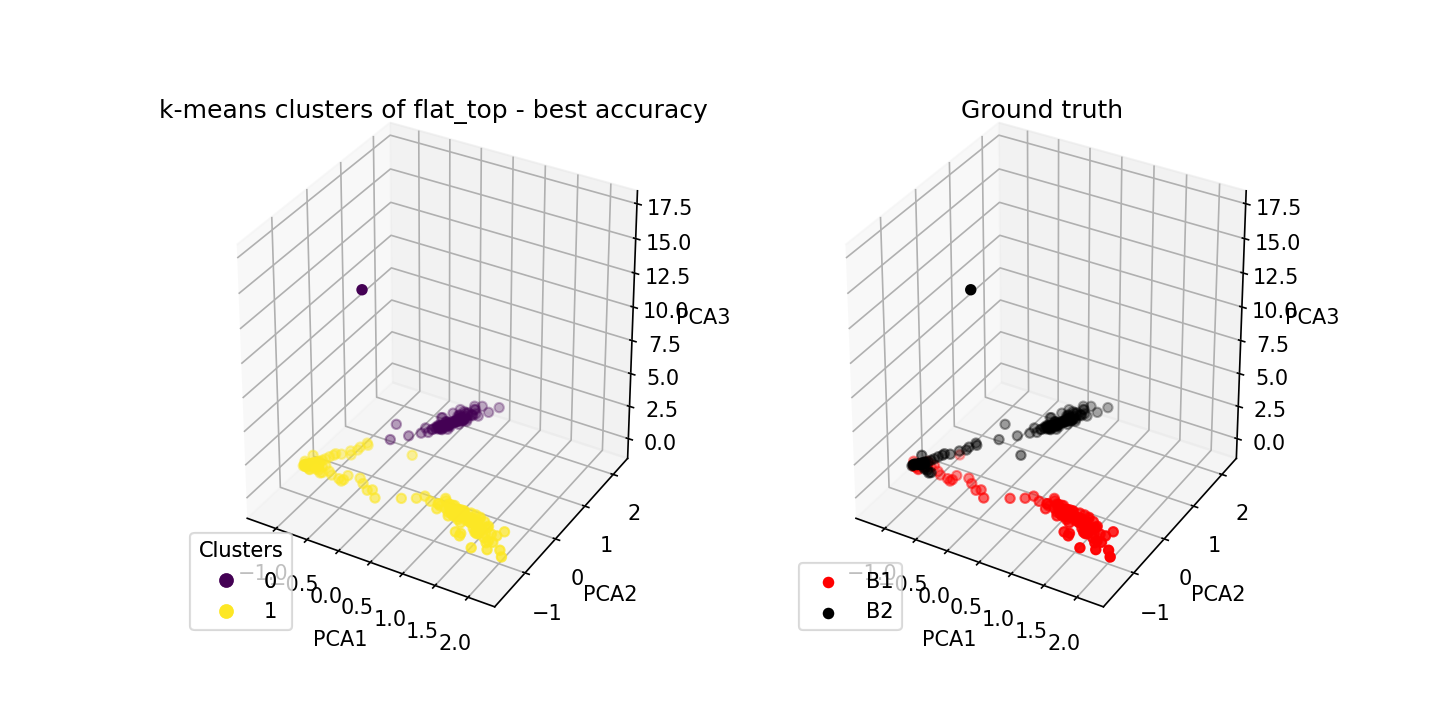

start_squeeze - PCA
Accuracies std dev = 0.005323014465151283
Accuracies mean = 0.8995729746387169

Worst performing clustering result:
	Average accuracy = 88.95%

	Cluster 0
		Proportion	61.30% (141/230)
		of which B1	80.14% (113/141)
		of which B2	19.86% (28/141)
		Time std dev	23 days 16:27:03
		Time mean	2018-08-21 08:37:48

	Cluster 1
		Proportion	38.70% (89/230)
		of which B1	2.25% (2/89)
		of which B2	97.75% (87/89)
		Time std dev	20 days 07:12:07
		Time mean	2018-08-20 17:46:52



<IPython.core.display.Javascript object>


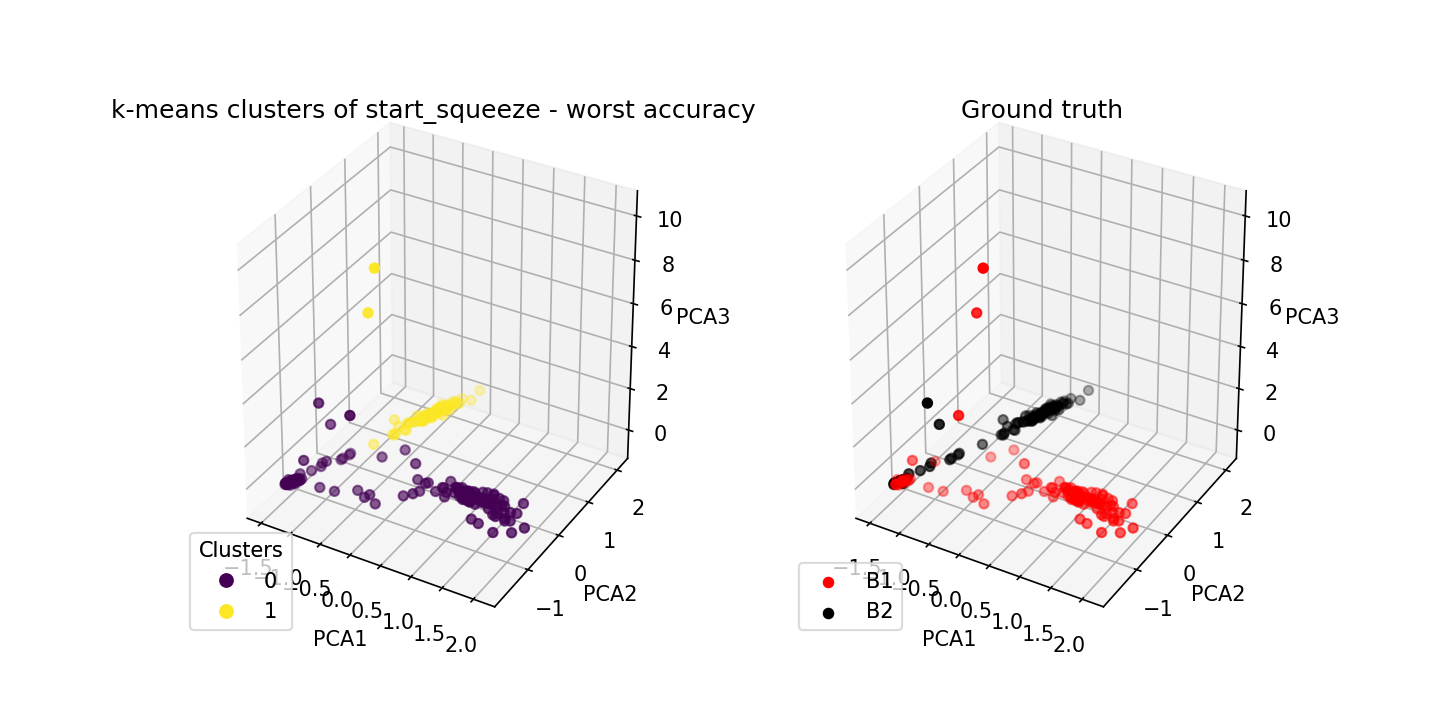

Best performing clustering result:
	Average accuracy = 90.21%

	Cluster 0
		Proportion	62.17% (143/230)
		of which B1	80.42% (115/143)
		of which B2	19.58% (28/143)
		Time std dev	23 days 16:40:48
		Time mean	2018-08-21 03:05:04

	Cluster 1
		Proportion	37.83% (87/230)
		of which B1	0.00% (0/87)
		of which B2	100.00% (87/87)
		Time std dev	20 days 04:51:03
		Time mean	2018-08-21 02:33:17



<IPython.core.display.Javascript object>

start_adjust - PCA
Accuracies std dev = 0.0
Accuracies mean = 0.5085714285714286

Worst performing clustering result:
	Average accuracy = 50.86%

	Cluster 0
		Proportion	58.33% (140/240)
		of which B1	49.29% (69/140)
		of which B2	50.71% (71/140)
		Time std dev	17 days 18:01:59
		Time mean	2018-08-20 14:10:02

	Cluster 1
		Proportion	41.67% (100/240)
		of which B1	51.00% (51/100)
		of which B2	49.00% (49/100)
		Time std dev	27 days 18:22:51
		Time mean	2018-08-22 10:57:33



<IPython.core.display.Javascript object>

Best performing clustering result:
	Average accuracy = 50.86%

	Cluster 0
		Proportion	58.33% (140/240)
		of which B1	49.29% (69/140)
		of which B2	50.71% (71/140)
		Time std dev	17 days 18:01:59
		Time mean	2018-08-20 14:10:02

	Cluster 1
		Proportion	41.67% (100/240)
		of which B1	51.00% (51/100)
		of which B2	49.00% (49/100)
		Time std dev	27 days 18:22:51
		Time mean	2018-08-22 10:57:33



<IPython.core.display.Javascript object>


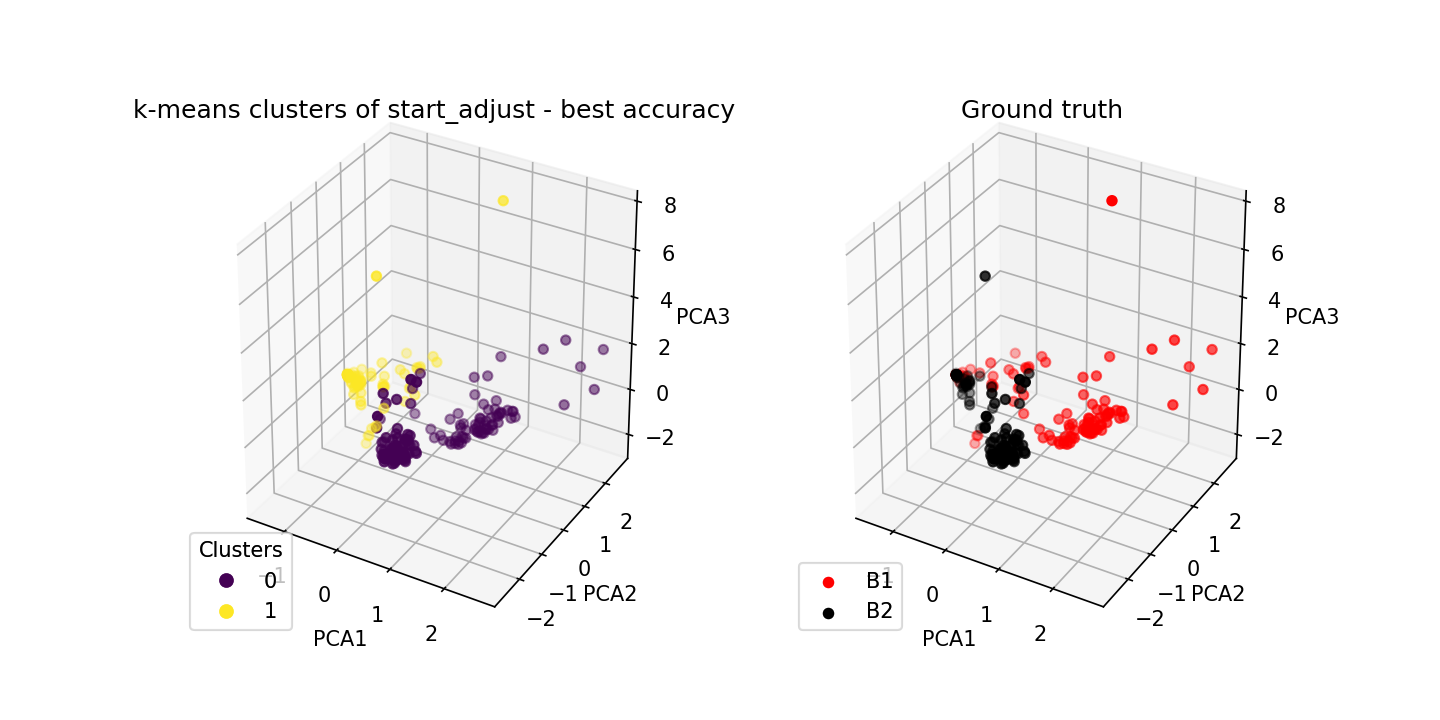

In [27]:
for phaseName, lossDf in lossDfsPCA.items():  
    print(f'{phaseName} - PCA')
    kmeansAnalysis(kmeans, lossDf, timestamps[phaseName], phaseName)

## DBSCAN



### Helper functions

In [28]:
def dbscanAnalysis(dbscan, lossDf, timestamps, phaseName):
    """ Runs DBSCAN on lossDf and displays clustering info.
    
    Plots are only done if lossDf is 3D.
    
    Parameters
    ----------
    dbscan : sklearn.cluster.DBSCAN object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    """
    labels = dbscan.fit_predict(lossDf)
    
    clusteringResult = ClusteringResult(labels, timestamps)
    clusteringResult.describe()
    
    if is3D(lossDf):
        scatterPlotClusters(lossDf, labels, f"DBSCAN clusters of {phaseName}")

### Analysis

In [29]:
# eps - "The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not
#        a maximum bound on the distances of points within a cluster. This is the most important DBSCAN parameter to choose 
#        appropriately for your data set and distance function."
# min_samples - "The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.
#                This includes the point itself."

dbscan = DBSCAN(eps=0.5, min_samples=15) # these params worked when PCA whiten=True
# dbscan = DBSCAN(eps=1.4, min_samples=15)
                                        # if whiten=False, try eps=1, min_samples=6 and eps=1.4, min=15 - 5% of startRamp len
                                        # looks like if min_samples goes up, eps must also ... otherwise we are expecting
        # a very dense neighbourhood for a point to be a core point if we have a small eps (radius) and a high min_samples.
        # eg. eps=0.3, min_samples=6 worked (PCA whiten=True).  but boosting min_samples to 15, I also boosted eps to 0.5
        # and this gave me the "nicest" result yet
# from Wikipedia = as a rule of thumb, 2*dimensions (2*3 = 6) can be used

#### Full feature-space

In [30]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    dbscanAnalysis(dbscan, lossDf, timestamps[phaseName], phaseName)

start_ramp
	Average accuracy = 50.00%

	Cluster -1
		Proportion	100.00% (302/302)
		of which B1	50.00% (151/302)
		of which B2	50.00% (151/302)
		Time std dev	22 days 23:08:12
		Time mean	2018-08-20 12:55:10

flat_top
	Average accuracy = 83.54%

	Cluster -1
		Proportion	81.13% (245/302)
		of which B1	49.39% (121/245)
		of which B2	50.61% (124/245)
		Time std dev	22 days 22:21:08
		Time mean	2018-08-21 01:00:15

	Cluster 0
		Proportion	9.93% (30/302)
		of which B1	100.00% (30/30)
		of which B2	0.00% (0/30)
		Time std dev	23 days 16:52:54
		Time mean	2018-08-20 14:34:49

	Cluster 1
		Proportion	8.94% (27/302)
		of which B1	0.00% (0/27)
		of which B2	100.00% (27/27)
		Time std dev	23 days 22:52:23
		Time mean	2018-08-21 17:41:11

start_squeeze
	Average accuracy = 50.00%

	Cluster -1
		Proportion	100.00% (230/230)
		of which B1	50.00% (115/230)
		of which B2	50.00% (115/230)
		Time std dev	22 days 09:25:04
		Time mean	2018-08-21 02:53:03

start_adjust
	Average accuracy = 51.39%

	Cluster -

#### PCA features

start_ramp - PCA
	Average accuracy = 75.29%

	Cluster -1
		Proportion	19.21% (58/302)
		of which B1	41.38% (24/58)
		of which B2	58.62% (34/58)
		Time std dev	22 days 23:17:36
		Time mean	2018-08-16 12:23:10

	Cluster 0
		Proportion	23.18% (70/302)
		of which B1	100.00% (70/70)
		of which B2	0.00% (0/70)
		Time std dev	19 days 20:39:27
		Time mean	2018-08-22 09:08:56

	Cluster 1
		Proportion	57.62% (174/302)
		of which B1	32.76% (57/174)
		of which B2	67.24% (117/174)
		Time std dev	24 days 01:35:35
		Time mean	2018-08-21 03:18:13



<IPython.core.display.Javascript object>


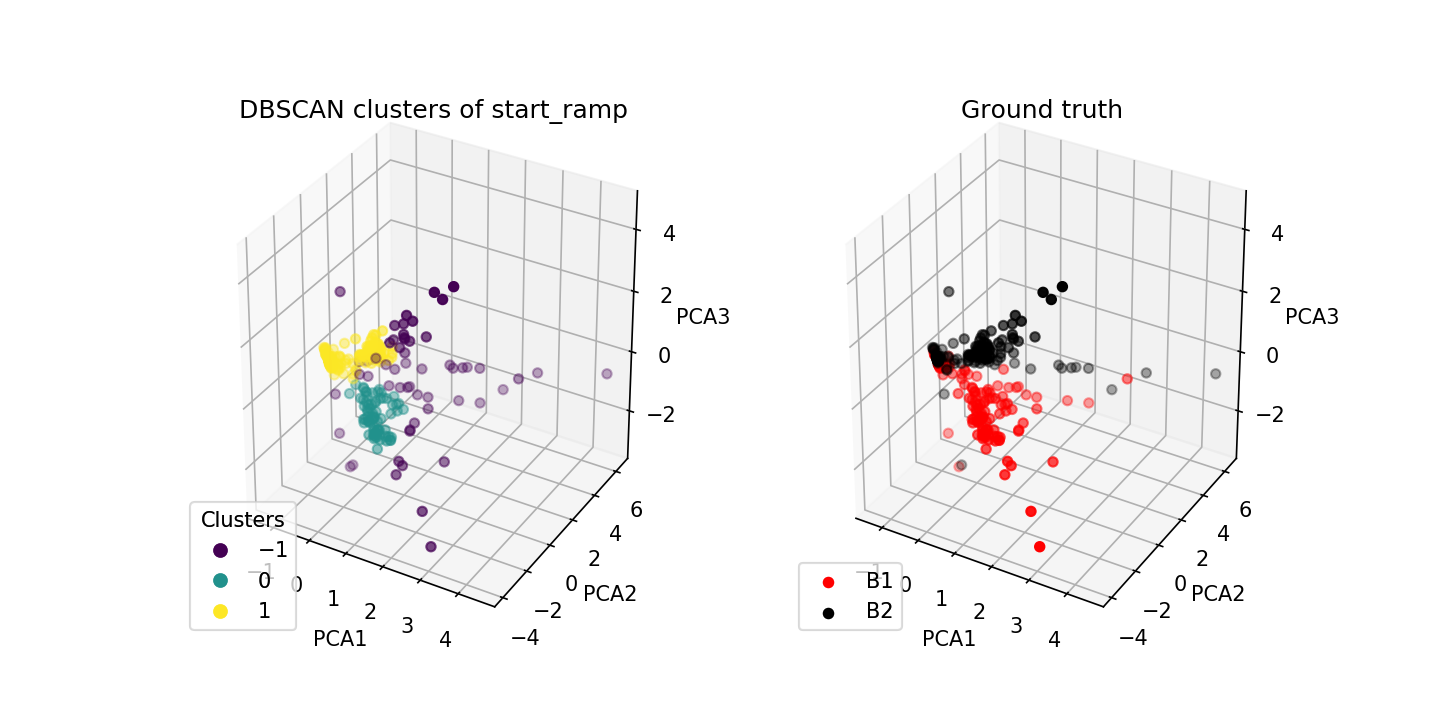

flat_top - PCA
	Average accuracy = 82.71%

	Cluster -1
		Proportion	1.66% (5/302)
		of which B1	20.00% (1/5)
		of which B2	80.00% (4/5)
		Time std dev	22 days 12:12:12
		Time mean	2018-08-06 23:55:14

	Cluster 0
		Proportion	29.80% (90/302)
		of which B1	100.00% (90/90)
		of which B2	0.00% (0/90)
		Time std dev	20 days 21:58:10
		Time mean	2018-08-20 19:46:48

	Cluster 1
		Proportion	39.07% (118/302)
		of which B1	50.85% (60/118)
		of which B2	49.15% (58/118)
		Time std dev	25 days 22:14:46
		Time mean	2018-08-21 22:27:03

	Cluster 2
		Proportion	29.47% (89/302)
		of which B1	0.00% (0/89)
		of which B2	100.00% (89/89)
		Time std dev	21 days 00:13:27
		Time mean	2018-08-20 22:20:11



<IPython.core.display.Javascript object>


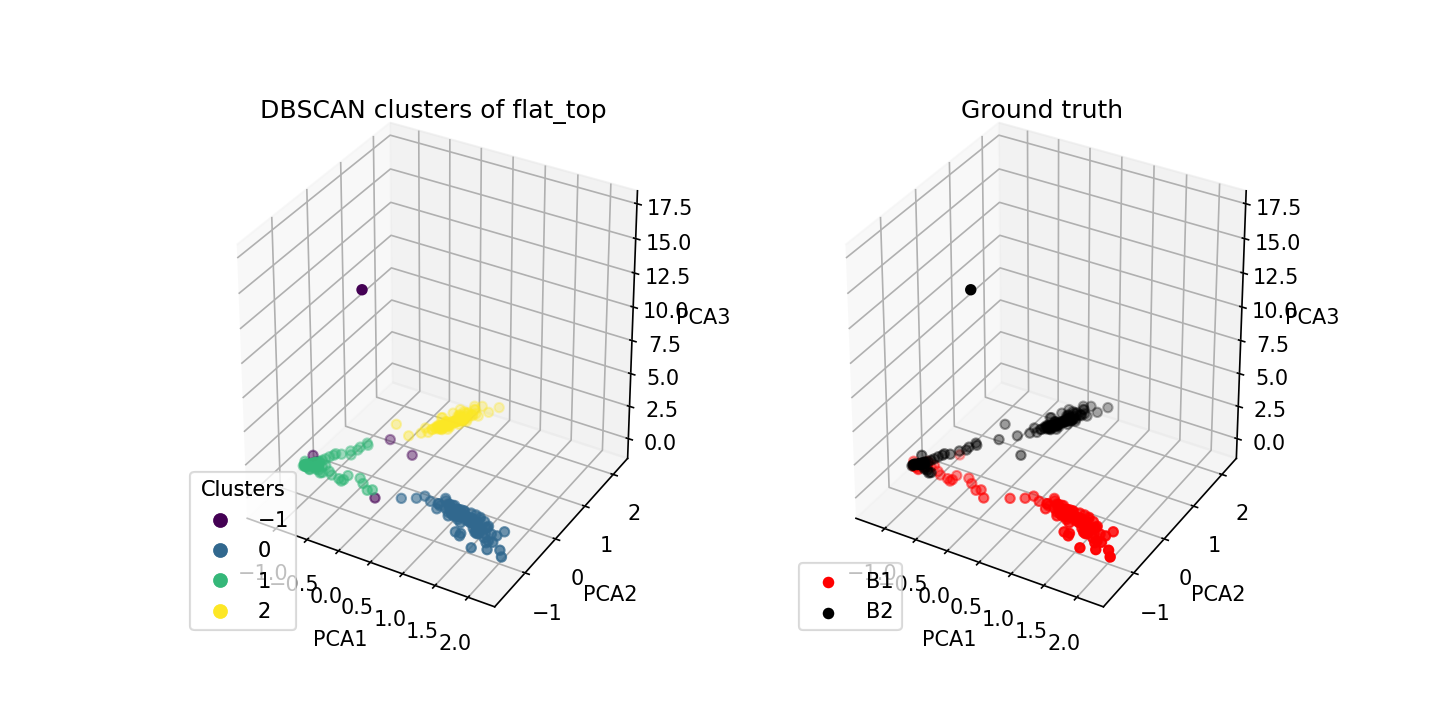

start_squeeze - PCA
	Average accuracy = 78.88%

	Cluster -1
		Proportion	8.26% (19/230)
		of which B1	63.16% (12/19)
		of which B2	36.84% (7/19)
		Time std dev	26 days 04:43:35
		Time mean	2018-08-10 00:31:20

	Cluster 0
		Proportion	36.09% (83/230)
		of which B1	100.00% (83/83)
		of which B2	0.00% (0/83)
		Time std dev	20 days 06:44:48
		Time mean	2018-08-21 04:37:22

	Cluster 1
		Proportion	18.26% (42/230)
		of which B1	47.62% (20/42)
		of which B2	52.38% (22/42)
		Time std dev	27 days 06:24:02
		Time mean	2018-08-25 19:02:30

	Cluster 2
		Proportion	37.39% (86/230)
		of which B1	0.00% (0/86)
		of which B2	100.00% (86/86)
		Time std dev	20 days 07:01:28
		Time mean	2018-08-21 05:16:44



<IPython.core.display.Javascript object>


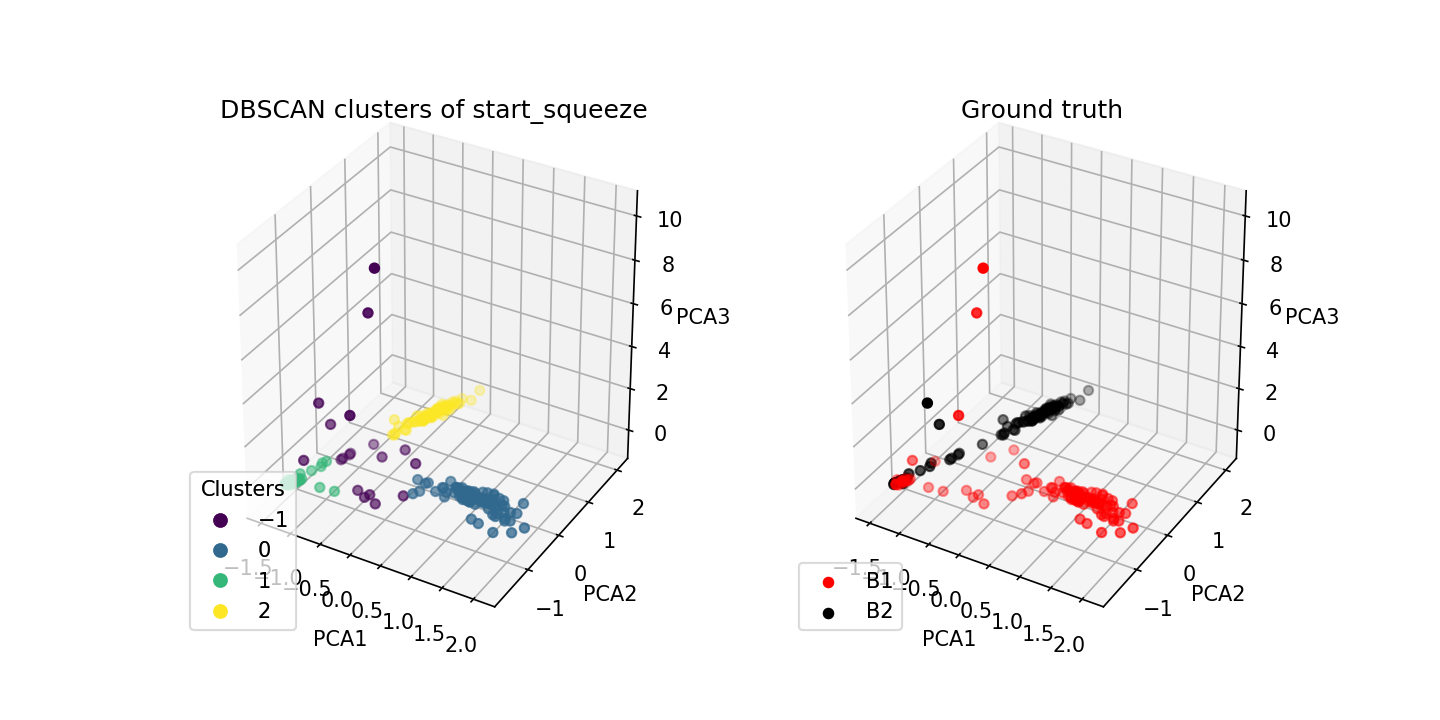

start_adjust - PCA
	Average accuracy = 75.21%

	Cluster -1
		Proportion	24.58% (59/240)
		of which B1	49.15% (29/59)
		of which B2	50.85% (30/59)
		Time std dev	26 days 17:53:43
		Time mean	2018-08-23 14:31:08

	Cluster 0
		Proportion	26.67% (64/240)
		of which B1	50.00% (32/64)
		of which B2	50.00% (32/64)
		Time std dev	27 days 00:36:05
		Time mean	2018-08-22 23:31:07

	Cluster 1
		Proportion	24.58% (59/240)
		of which B1	100.00% (59/59)
		of which B2	0.00% (0/59)
		Time std dev	17 days 00:04:00
		Time mean	2018-08-19 16:52:29

	Cluster 2
		Proportion	24.17% (58/240)
		of which B1	0.00% (0/58)
		of which B2	100.00% (58/58)
		Time std dev	16 days 06:45:16
		Time mean	2018-08-19 00:10:15



<IPython.core.display.Javascript object>

In [31]:
for phaseName, lossDf in lossDfsPCA.items():
    print(f'{phaseName} - PCA')
    dbscanAnalysis(dbscan, lossDf, timestamps[phaseName], phaseName)

## Linear classifier

Here we deliberately use linear classifiers because we are interested in finding asymmetry if it exists.  The worse the classifier does at linearly separating the data, the more symmetric the data.  The better the classifier does at linearly separating the data, the more asymmetric the data.

### Helper functions

In [32]:
def plotClassifierPlane(lossDf, phaseName, clf):
    """ Scatter plots losses in `lossDf` and includes decision boundary plane found by the linear classifier `clf`.
    
    Parameters
    ----------
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    phaseName : str
    clf : sklearn.svm.LinearSVC object
        Note: the object must have been fitted (i.e. its fit( ) method must have been called).  Used to obtain the plane.
    """
    # Note: https://matplotlib.org/mpl_toolkits/mplot3d/faq.html#my-3d-plot-doesn-t-look-right-at-certain-viewing-angles
    #"This is probably the most commonly reported issue with mplot3d. The problem is that – from some viewing angles – a 
    #3D object would appear in front of another object, even though it is physically behind it."

    fig = plt.figure(figsize=[4, 4])
    ax = fig.add_subplot(111, projection='3d')
    scatterPlotLosses(lossDf, f"Linear SVC decision plane on {phaseName}", ax)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
#     zlim = ax.get_zlim() - for having same scale on axes as original plot (before adding the surface)
    x, y = np.meshgrid(np.linspace(xlim[0], xlim[1], 2),
                         np.linspace(ylim[0], ylim[1], 2))
    z = lambda x, y: (-clf.intercept_[0]-clf.coef_[0][0]*x-clf.coef_[0][1]*y) / clf.coef_[0][2]
    
#     ax.set_zlim(zlim) - for having same scale on axes as original plot (before adding the surface)
    ax.plot_surface(x, y, z(x,y), alpha=0.9)

In [33]:
def linearClassifierAnalysis(clf, lossDf, timestamps, phaseName):
    """ Fits a linear classifier to `lossDf` and displays clustering info - where in this case the "clusters" are actually
    the two sides of the decision boundary.
    
    Plots are only done if `lossDf` is 3D.
    
    Parameters
    ----------
    clf : sklearn.svm.LinearSVC object
    lossDf : DataFrame of floats
        Loss DataFrame, without timestamps column, but otherwise identical in structure to the DataFrames saved by the 
        Data Collection notebook.
    timestamps : Series of float
            Timestamps corresponding to each training sample in lossDf
    phaseName : str
    """
    samplesCount = len(lossDf)
    
    # make ground truth labels used by the linear classifier - where each element of the list corresponds to a row
    #     1 means the corresponding row is a B1 loss
    #     2 means the corresponding row is a B2 loss
    classes = ([1] * (samplesCount // 2)) + ([2] * (samplesCount // 2))

    # test that class 1 corresponds to 'B1' index in the dataframe, class 2 corresponds to 'B2'
    for idx, c in enumerate(classes):
        assert (c == 1 and lossDf.iloc[idx].name[0] == 'B1') or (c == 2 and lossDf.iloc[idx].name[0] == 'B2')

    clf.fit(lossDf, classes)

    result = ClusteringResult(clf.predict(lossDf), timestamps)
    result.describe()
    
    if is3D(lossDf):
        plotClassifierPlane(lossDf, phaseName, clf)

### Analysis

In [34]:
clf = svm.LinearSVC(dual=False) # docs: "Prefer dual=False when n_samples > n_features"

#### Full feature-space

In [35]:
for phaseName, lossDf in lossDfs.items():
    print(phaseName)
    linearClassifierAnalysis(clf, lossDf, timestamps[phaseName], phaseName)

start_ramp
	Average accuracy = 100.00%

	Cluster 1
		Proportion	50.00% (151/302)
		of which B1	100.00% (151/151)
		of which B2	0.00% (0/151)
		Time std dev	23 days 00:03:16
		Time mean	2018-08-20 12:55:10

	Cluster 2
		Proportion	50.00% (151/302)
		of which B1	0.00% (0/151)
		of which B2	100.00% (151/151)
		Time std dev	23 days 00:03:16
		Time mean	2018-08-20 12:55:10

flat_top
	Average accuracy = 100.00%

	Cluster 1
		Proportion	50.00% (151/302)
		of which B1	100.00% (151/151)
		of which B2	0.00% (0/151)
		Time std dev	23 days 01:27:09
		Time mean	2018-08-21 01:27:36

	Cluster 2
		Proportion	50.00% (151/302)
		of which B1	0.00% (0/151)
		of which B2	100.00% (151/151)
		Time std dev	23 days 01:27:09
		Time mean	2018-08-21 01:27:36

start_squeeze
	Average accuracy = 99.57%

	Cluster 1
		Proportion	50.43% (116/230)
		of which B1	99.14% (115/116)
		of which B2	0.86% (1/116)
		Time std dev	22 days 14:05:28
		Time mean	2018-08-21 10:15:15

	Cluster 2
		Proportion	49.57% (114/230)
		of which

#### PCA features

start_ramp - PCA
	Average accuracy = 90.52%

	Cluster 1
		Proportion	44.70% (135/302)
		of which B1	94.81% (128/135)
		of which B2	5.19% (7/135)
		Time std dev	22 days 02:14:17
		Time mean	2018-08-21 04:49:13

	Cluster 2
		Proportion	55.30% (167/302)
		of which B1	13.77% (23/167)
		of which B2	86.23% (144/167)
		Time std dev	23 days 16:43:44
		Time mean	2018-08-20 00:03:55



<IPython.core.display.Javascript object>

flat_top - PCA
	Average accuracy = 95.40%

	Cluster 1
		Proportion	48.68% (147/302)
		of which B1	96.60% (142/147)
		of which B2	3.40% (5/147)
		Time std dev	22 days 23:44:44
		Time mean	2018-08-21 00:51:18

	Cluster 2
		Proportion	51.32% (155/302)
		of which B1	5.81% (9/155)
		of which B2	94.19% (146/155)
		Time std dev	23 days 03:03:55
		Time mean	2018-08-21 02:02:02



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


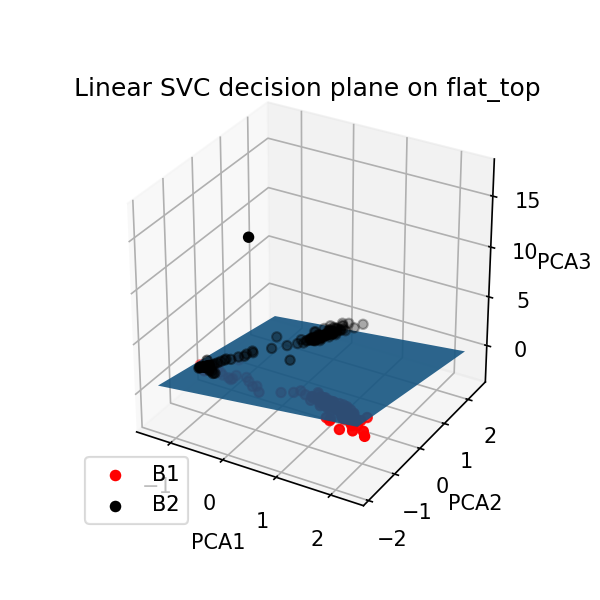

start_squeeze - PCA
	Average accuracy = 93.16%

	Cluster 1
		Proportion	44.35% (102/230)
		of which B1	98.04% (100/102)
		of which B2	1.96% (2/102)
		Time std dev	22 days 01:11:46
		Time mean	2018-08-20 20:55:13

	Cluster 2
		Proportion	55.65% (128/230)
		of which B1	11.72% (15/128)
		of which B2	88.28% (113/128)
		Time std dev	22 days 17:54:26
		Time mean	2018-08-21 07:38:12



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


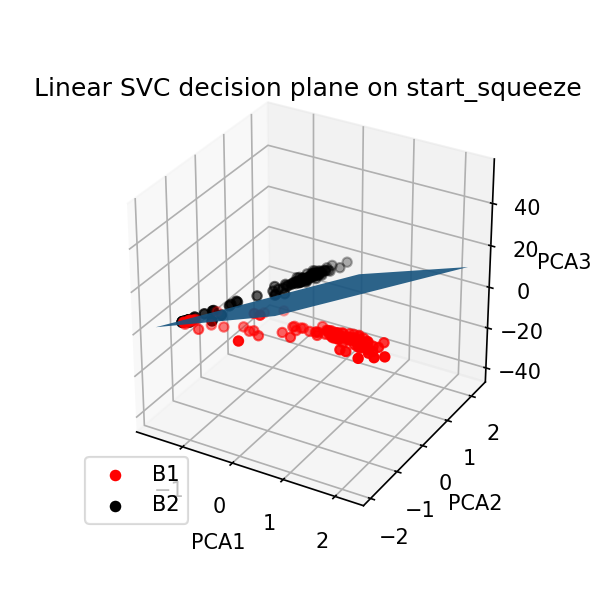

start_adjust - PCA
	Average accuracy = 90.07%

	Cluster 1
		Proportion	57.50% (138/240)
		of which B1	84.06% (116/138)
		of which B2	15.94% (22/138)
		Time std dev	23 days 05:47:01
		Time mean	2018-08-21 20:27:56

	Cluster 2
		Proportion	42.50% (102/240)
		of which B1	3.92% (4/102)
		of which B2	96.08% (98/102)
		Time std dev	21 days 09:35:03
		Time mean	2018-08-20 17:05:20



C:\Users\mvell\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


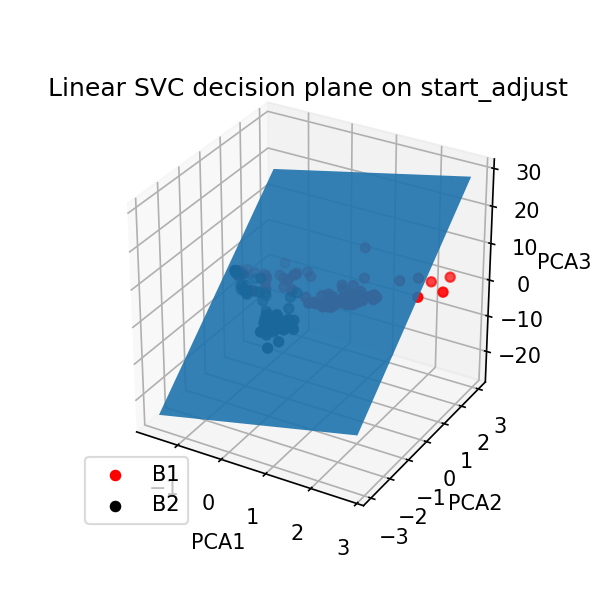

In [36]:
for phaseName, lossDf in lossDfsPCA.items():
    print(f'{phaseName} - PCA')
    linearClassifierAnalysis(clf, lossDf, timestamps[phaseName], phaseName)